Loading Data and Modules

In [102]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input,Concatenate
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [92]:
train=pd.read_csv("../input/X_train.csv")

In [93]:
sub=pd.read_csv("../input/sample_submission.csv")

In [94]:
y=pd.read_csv("../input/y_train.csv")

In [95]:
y.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Mergigng Train and Target Datasets

In [96]:
train=train.merge(y,on='series_id',how='left')

In [97]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


In [98]:
train['surface'].value_counts()

concrete                  99712
soft_pvc                  93696
wood                      77696
tiled                     65792
fine_concrete             46464
hard_tiles_large_space    39424
soft_tiles                38016
carpet                    24192
hard_tiles                 2688
Name: surface, dtype: int64

Label encoding target variable

In [100]:


target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)


Train Test split

In [103]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (390144, 10)
Validation shape (97536, 10)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
174517,-0.22351,0.96262,0.147250,-0.041492,-0.023037,0.107670,-0.313830,0.016821,3.8752,-11.1430
434895,-0.54943,-0.82225,-0.127320,-0.076376,0.356350,-0.165830,0.212980,1.202700,11.1940,-7.9759
385247,0.78303,0.60372,0.097223,0.113750,0.064847,0.148310,-0.374690,-0.033998,2.8156,-10.2200
374689,0.92600,0.34640,0.059994,0.137600,0.096735,-0.049043,0.144260,-0.457680,3.9749,-5.1218
297812,-0.66945,-0.72716,-0.115300,-0.098892,0.215470,-0.010674,0.022843,1.427000,6.0013,-9.4340


Model 

In [104]:
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=10))
model.add(Dense(20, activation='relu'))
model.add(Dense(9, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 189       
Total params: 829
Trainable params: 829
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(X_train.values, Y_train, validation_data=(X_val.values, Y_val), verbose=2,epochs=7,batch_size=128)

Train on 390144 samples, validate on 97536 samples
Epoch 1/7
 - 6s - loss: 1.7278 - val_loss: 1.5715
Epoch 2/7
 - 5s - loss: 1.4971 - val_loss: 1.4333
Epoch 3/7
 - 5s - loss: 1.3825 - val_loss: 1.3530
Epoch 4/7
 - 5s - loss: 1.3221 - val_loss: 1.2992
Epoch 5/7
 - 5s - loss: 1.2701 - val_loss: 1.2623
Epoch 6/7
 - 5s - loss: 1.2343 - val_loss: 1.2279
Epoch 7/7
 - 6s - loss: 1.2111 - val_loss: 1.2017


Predictions on Test 

In [106]:
test=pd.read_csv("../input/X_test.csv")

In [ ]:
test.head()

In [107]:
Test=test[['orientation_X','orientation_Y','orientation_Z','orientation_W','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']]

In [108]:
y_pred=model.predict(Test)

In [109]:
out=pd.DataFrame(y_pred)

In [110]:
out1=out.idxmax(axis=1)

In [111]:
out1.tail()

488443    8
488444    8
488445    8
488446    8
488447    8
dtype: int64

In [112]:
out1.value_counts()

1    128214
8     94222
7     79979
5     76517
6     51561
4     26831
2     22963
0      8082
3        79
dtype: int64

Confusion Matrix

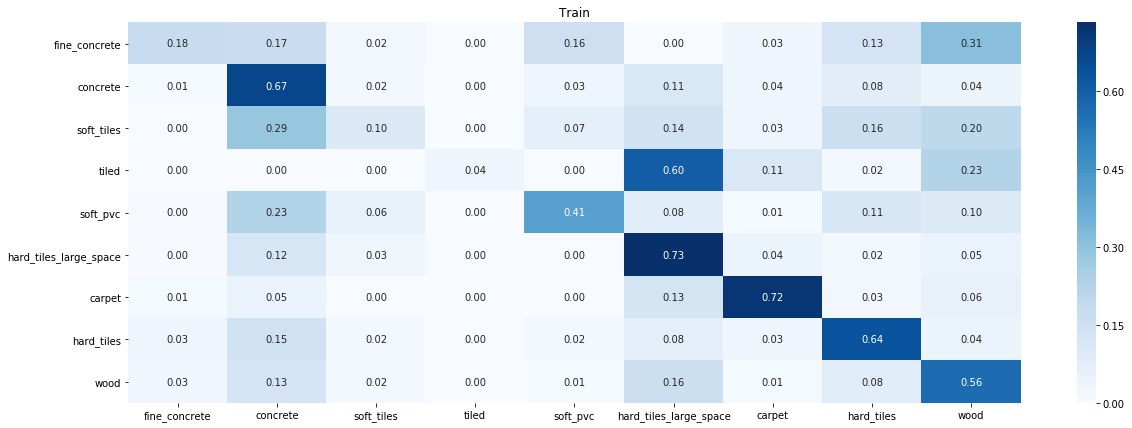

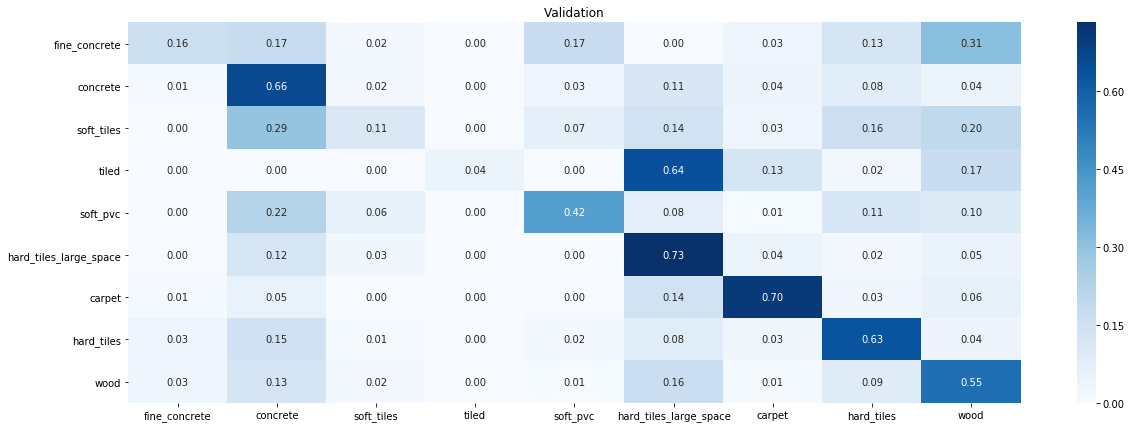

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cnf_matrix = confusion_matrix(np.argmax(Y_train, axis=1), model.predict_classes(X_train))
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), model.predict_classes(X_val))
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

In [116]:
predictions = model.predict_classes(test[features].values)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,tiled
1,1,concrete
2,2,tiled
3,3,wood
4,4,soft_tiles
5,5,concrete
6,6,concrete
7,7,concrete
8,8,concrete
9,9,wood
